In [3]:
import pandas as pd 
import numpy as np 
from sklearn import model_selection, metrics, preprocessing
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

In [4]:
rawData = pd.read_csv("../DataSet/winequality-white.csv", delimiter=";")
rawData

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [5]:
X = rawData.values[:, :-1]
y = rawData.values[:, -1]
y_class = np.where(y<6, 0, 1).reshape(-1, 1)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class.ravel(), train_size=0.7)

In [5]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

#  SVM with two classes

In [6]:
from sklearn import svm
classifier = svm.SVC(kernel="rbf", gamma=0.01)
classifier.fit(X_train_std, y_train)

SVC(gamma=0.01)

In [7]:
y_test_pred = classifier.predict(X_test_std)
y_test_pred

array([1, 1, 1, ..., 1, 0, 1])

In [8]:
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)
auc = metrics.auc(fpr, tpr)

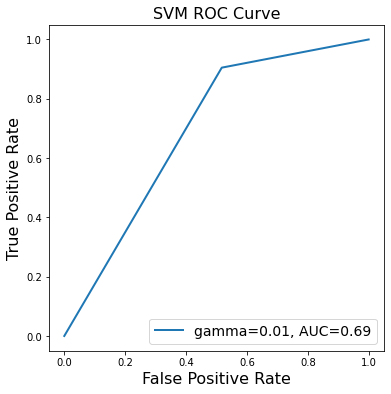

In [9]:
# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

## Avec Grid Search et Hyperparameters

In [10]:
params_grid = {"C": np.logspace(-5, 5, 10) , "gamma": np.logspace(-5, 5, 10)}
gridSearch = model_selection.GridSearchCV(svm.SVC(kernel="rbf"), params_grid, cv=5, scoring="roc_auc")
gridSearch.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'gamma': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             scoring='roc_auc')

In [11]:
print("The optimal parameters are {} with a score of {:.2f}".format(gridSearch.best_params_, gridSearch.best_score_))

The optimal parameters are {'C': 0.2782559402207126, 'gamma': 3.593813663804626} with a score of 0.83


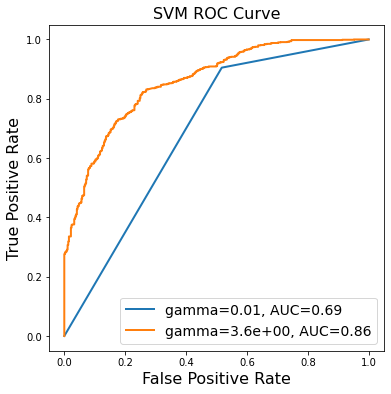

In [12]:
# prédire sur le jeu de test avec le modèle optimisé
y_test_pred_cv = gridSearch.decision_function(X_test_std)

# construire la courbe ROC du modèle optimisé
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_test_pred_cv)

# calculer l'aire sous la courbe ROC du modèle optimisé
auc_cv = metrics.auc(fpr_cv, tpr_cv)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
         (gridSearch.best_params_['gamma'], auc_cv))
         

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

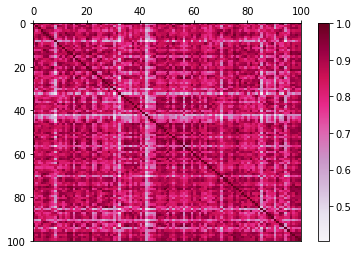

In [13]:
from sklearn import metrics
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.01)
kmatrixG28 = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.27)
#on ne garde que les 100 premières lignes et 100 premières colonnes. 
kmatrix100 = kmatrix[:100, :100]
kmatrix100G28 = kmatrixG28[:100, :100]
# dessiner la matrice
plt.pcolor(kmatrix100, cmap=plt.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

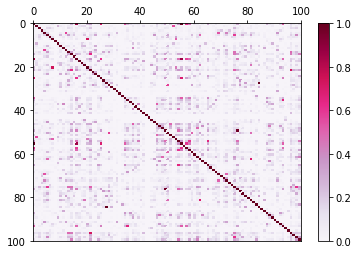

In [14]:
kmatrixG28 = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.27)
kmatrix100G28 = kmatrixG28[:100, :100]

plt.pcolor(kmatrix100G28, cmap=plt.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

## Avec un gamma de 50

In [15]:
#test avec un gamma à 50 
classifier = svm.SVC(kernel="rbf", gamma=50, C=3.593813663804626)
classifier.fit(X_train_std, y_train)
y_pred_gamma50 = classifier.predict(X_test_std)

In [16]:
fpr_cv50, tpr_cv50, thr_cv50 = metrics.roc_curve(y_test, y_pred_gamma50)
auc_cv50 = metrics.auc(fpr_cv50, tpr_cv50)

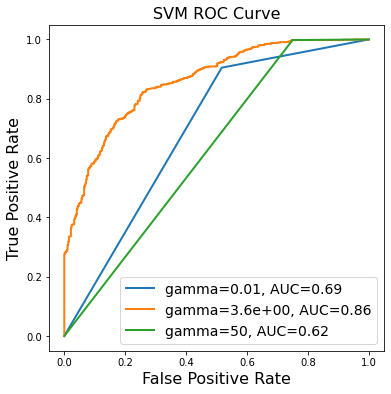

In [17]:
# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
         (gridSearch.best_params_['gamma'], auc_cv))
         
# afficher la courbe ROC du modèle avec un gamma de 50
plt.plot(fpr_cv50, tpr_cv50, '-', lw=2, label='gamma=50, AUC=%.2f' % \
         (auc_cv50))

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

# Work with binarize Y

In [115]:
X = rawData.values[:, :-1]
encoder = preprocessing.StandardScaler()
X_std = encoder.fit_transform(X)
y = rawData.values[:, -1]
y_bool = np.where(y<6, 0, 1)
#print(y_bool)
#y_numeric = encoder.fit_transform(y_bool)
X_train_num, X_test_num, y_train_num, y_test_num = model_selection.train_test_split(X_std, y_bool, train_size=0.7)
X_train_num2, X_test_num2, y_train_num2, y_test_num2 = model_selection.train_test_split(X_std, y, train_size=0.7)

In [111]:
params_grid = {"estimator__C": np.logspace(-5, 5, 10) , "estimator__gamma": np.logspace(-5, 5, 10)}
gridSearchNum = model_selection.GridSearchCV(OneVsOneClassifier(svm.SVC(kernel="rbf")), params_grid, cv=5)
gridSearchNum.fit(X_train_num, y_train_num)

GridSearchCV(cv=5, estimator=OneVsOneClassifier(estimator=SVC()),
             param_grid={'estimator__C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'estimator__gamma': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})

In [113]:
gridSearchNum.best_params_

{'estimator__C': 3.593813663804626, 'estimator__gamma': 0.2782559402207126}

In [114]:
gridSearchNum.best_score_

0.8016343555148859

# Percpetrons with only one layers
### and multiple class classifer


In [7]:
X = rawData.values[:, :-1]
encoder = preprocessing.StandardScaler()
X_std = encoder.fit_transform(X)
y = rawData.values[:, -1]
X_train_num2, X_test_num2, y_train_num2, y_test_num2 = model_selection.train_test_split(X_std, y, train_size=0.7)

In [8]:
percept = Perceptron()
percept.fit(X_train_num2, y_train_num2)

Perceptron()

In [48]:
percept.score(X_test_num2, y_test_num2)

0.42857142857142855

In [56]:
params_grid = {"alpha": list(np.linspace(0.0001,1, 10)) , "penalty": ["l1", "l2"]} #, "solver": ["lbfgs", "sgd", "adam"]}#, "activation" : ["identity", "logistic", "tanh", "relu"]}
perceptCV = model_selection.GridSearchCV(Perceptron(), params_grid, cv=5)
perceptCV.fit(X_test_num2, y_test_num2)

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'alpha': [0.0001, 1.1112, 2.2223, 3.3334, 4.4445,
                                   5.5556, 6.6667, 7.777799999999999, 8.8889,
                                   10.0],
                         'penalty': ['l1', 'l2']})

In [58]:
perceptCV.best_score_

0.4414965986394558

### Perceptrons with multiple layers 

In [ ]:
params_grid = {"alpha": list(np.linspace(0.0001,1, 10)) , "hidden_layer_sizes": list(range(1, 100, 10)), "solver": ["lbfgs", "sgd", "adam"], "activation" : ["identity", "logistic", "tanh", "relu"]}
perceptCVMLP = model_selection.GridSearchCV(MLPClassifier(max_iter=1000), params_grid, cv=5)
perceptCVMLP.fit(X_train_num2, y_train_num2)

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization ha

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/benjamindeplus/.local/share/virtualenvs/Seattle2050-kF-VE2eh/li

In [146]:
perceptCVMLP.best_params_

{'alpha': 7.742636826811269, 'hidden_layer_sizes': 81, 'solver': 'lbfgs'}

In [126]:
list(range(0, 10, 1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]